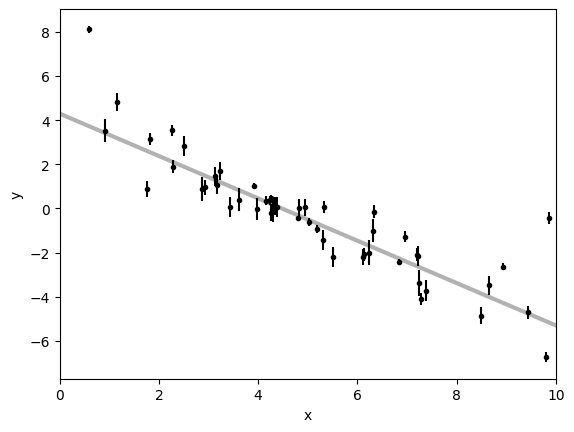

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
xp = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
yp = m_true * xp + b_true
yp += np.abs(f_true * yp) * np.random.randn(N)
yp += yerr * np.random.randn(N)

plt.errorbar(xp, yp, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [2]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(xp, yp, yerr))
m_ml, b_ml, log_f_ml = soln.x

def log_prior(theta):
    m, b, log_f = theta
    mlow = -5.0
    mhigh = 0.5
    blow = 0.0
    bhigh = 10.0
    flow = -10.0
    fhigh = 1.0
    if mlow < m < mhigh and blow < b < bhigh and flow < log_f < fhigh:
        return np.log(1/((mhigh-mlow)*(bhigh-blow)*(fhigh-flow)))
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [3]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(xp, yp, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True, store=True);

100%|██████████| 5000/5000 [00:03<00:00, 1628.07it/s]


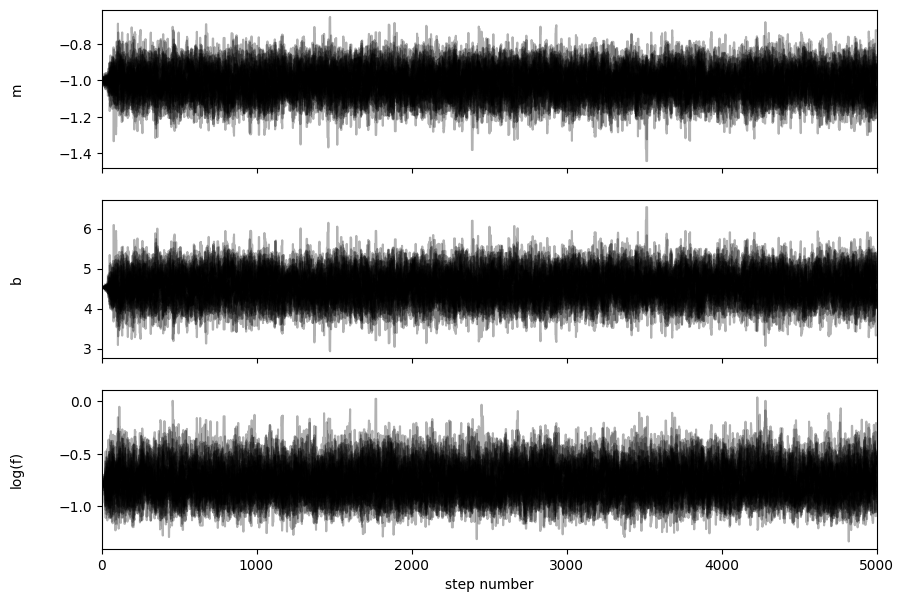

In [4]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [5]:
#tau = sampler.get_autocorr_time()
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [6]:
print(flat_samples)
print(flat_samples[0][0])
print(flat_samples[0][1])
print(flat_samples[0][2])
print(np.shape(flat_samples))

[[-1.03396208  4.59728125 -1.04137991]
 [-1.1046263   4.95527383 -0.85799926]
 [-0.95574285  4.2956599  -0.88717912]
 ...
 [-1.02408007  4.58529385 -0.64718915]
 [-1.00453143  4.39402519 -0.88498962]
 [-0.90800313  4.02018218 -0.66748968]]
-1.0339620789220567
4.597281245463738
-1.0413799095200116
(10432, 3)


In [9]:
import numpy as np
def log_like_distlin(b, c, log_f):
    model = b * xp + c
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((yp - model) ** 2 / sigma2 + np.log(sigma2))


def log_prior_distlin(b, c, log_f):
    M_low = -5.0
    M_high = 0.5
    B_low = 0.0
    B_high = 10.0
    f_low = -10.0
    f_high = 1.0

    if M_low < b < M_high and B_low < c < B_high and f_low < log_f < f_high:
        #the prior is saying that there is a 100% chance the parameters are within the above ranges, zero outside
        return np.log(1/((M_high-M_low)*(B_high-B_low)*(f_high-f_low)))      #this is log prior, so ln(1) = 0,
    return -np.inf  


def logpostlin2(b, c, log_f):
    lp = log_prior_distlin(b, c, log_f)       #this takes the log prior using the above
    #print("log prior: "+str(lp))

    if not np.isfinite(lp):     #checks if the parameters are within the ranges given by the prior
        return -np.inf          #log, so this really returns a 0% chance (outside prior range)
    
    ll = log_like_distlin(b, c, log_f)
    #print("log like: "+str(ll))
    lpost = lp+ll
    #print("log post: "+str(lpost))
    return -lpost, -lp

#shapelps = (1,np.shape(flat_samples)[0])
lpost=np.zeros(np.shape(flat_samples)[0])
lprior = np.zeros(np.shape(flat_samples)[0])
#sampweights = np.full(np.shape(flat_samples)[0], 1)
#print(lpost)

for i in range(np.shape(flat_samples)[0]):
    #originally, I had a ' - ' in front of logpostlin2 to make the answers negative, but that
    #returns an error because the output is a tuple and the operator '-' only takes one arguemnt
    #so instead i changed the output for logpostlin2 above to make the outputs negative
    lpost[i], lprior[i] = logpostlin2(flat_samples[i][0], flat_samples[i][1], flat_samples[i][2])

print(lpost)
print(lprior)

fullshape = (np.shape(flat_samples)[0], np.shape(flat_samples)[1]+3)
fullsamples = np.zeros(fullshape)

for i in range(np.shape(flat_samples)[0]):
    for j in range(np.shape(flat_samples)[1]):
        fullsamples[i][j] = flat_samples[i][j]
    fullsamples[i][np.shape(flat_samples)[1]] = lpost[i]
    fullsamples[i][np.shape(flat_samples)[1]+1] = lprior[i]
    fullsamples[i][np.shape(flat_samples)[1]+2] = 1.0

print(fullsamples)

[21.21074398 19.55244107 19.56973847 ... 19.51777661 22.36487195
 20.50730901]
[6.40522846 6.40522846 6.40522846 ... 6.40522846 6.40522846 6.40522846]
[[-1.03396208  4.59728125 -1.04137991 21.21074398  6.40522846  1.        ]
 [-1.1046263   4.95527383 -0.85799926 19.55244107  6.40522846  1.        ]
 [-0.95574285  4.2956599  -0.88717912 19.56973847  6.40522846  1.        ]
 ...
 [-1.02408007  4.58529385 -0.64718915 19.51777661  6.40522846  1.        ]
 [-1.00453143  4.39402519 -0.88498962 22.36487195  6.40522846  1.        ]
 [-0.90800313  4.02018218 -0.66748968 20.50730901  6.40522846  1.        ]]


Removed no burn in


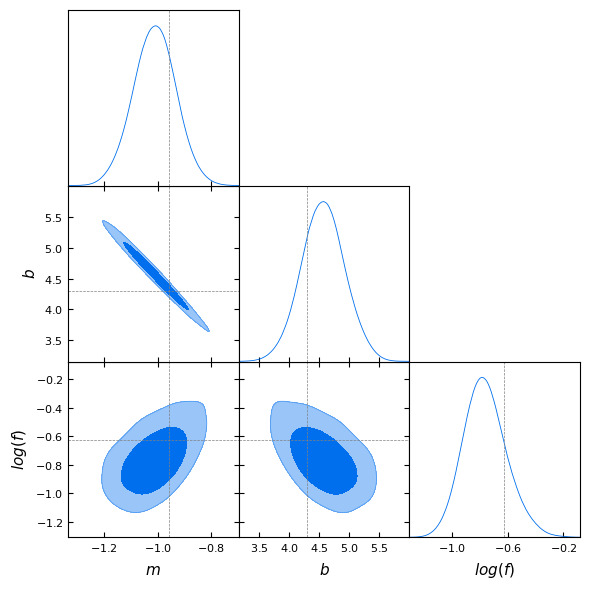

In [10]:
from getdist import plots, MCSamples
import getdist
names=['m','b','log(f)']

gdsamples = MCSamples(samples=flat_samples,names = names, labels = ['m','b','log(f)'])

g = plots.get_subplot_plotter()
g.triangle_plot(gdsamples, filled=True, markers={'m':m_true,'b':b_true,'log(f)':np.log(f_true)})

In [ ]:
#import copy
print(type(names))
fullnames = []
#fullnames.append('#')
#copynames = copy.deepcopy(names)
for i in range(np.shape(flat_samples)[1]):
    fullnames.append(names[i])
fullnames.append('minuslogpost')
fullnames.append('minuslogprior')
fullnames.append('weight')
print(fullnames)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df = pd.DataFrame(data=fullsamples, columns=fullnames)
#index=range(np.shape(flat_samples)[0]),
print(df)
#this seems to be good

#can i now save this as a text file and pass it to dfChains?
#np.savetxt('C:/Users/zombk/Documents/vscode/.venv/W2025coopcode/.venv/code_for_getting_started/BMA_cont/emceetest/emceechain.txt', df, fmt='%d')

#this seems correct
with open('emceechain2.txt', mode='w') as file_object:
    #print('#', file = file_object)
    print(df.to_string(index=False), file=file_object)
    #DONT FORGET TO INSERT A # IN THE FIRST TXT POSITION IN THE FILE

<class 'list'>
['m', 'b', 'log(f)', 'minuslogpost', 'minuslogprior', 'weight']
              m         b    log(f)  minuslogpost  minuslogprior  weight
0     -1.033962  4.597281 -1.041380     21.210744       6.405228     1.0
1     -1.104626  4.955274 -0.857999     19.552441       6.405228     1.0
2     -0.955743  4.295660 -0.887179     19.569738       6.405228     1.0
3     -0.993609  4.486580 -0.946404     19.432174       6.405228     1.0
4     -0.915234  4.088730 -0.464898     20.681390       6.405228     1.0
5     -0.893789  4.007394 -0.435551     20.810871       6.405228     1.0
6     -0.845210  3.795958 -0.337545     21.897403       6.405228     1.0
7     -1.113851  5.027400 -0.722138     20.204761       6.405228     1.0
8     -0.983802  4.276424 -0.578415     23.595431       6.405228     1.0
9     -0.877739  3.984736 -0.629516     19.938091       6.405228     1.0
10    -1.056165  4.757560 -0.753761     19.027243       6.405228     1.0
11    -1.053551  4.855876 -0.901888     20.45

In [ ]:
#not req
from  cobaya.prior import Prior

#maybe read through the documentation on this page?



In [62]:
#not req
import numpy as np
import pathlib


chainpath = "C:/Users/zombk/Documents/vscode/.venv/W2025coopcode/.venv/code_for_getting_started/BMA_cont/emceetest/"
chainPath = pathlib.Path(chainpath)
for file in chainPath.iterdir():
    chaindata = np.loadtxt(file)



ValueError: could not convert string '{' to float64 at row 0, column 1.

In [13]:
import FastMPClinpara as fmpc

roots = ["\emceechain2.txt"] # this might not be correct
models = ["lin"]
temperature = {'lin': 1}
model_prior = {'lin': 1.0}
parameters = {'lin':['m','b','log(f)']}        #these have to match the parameter names in the .txt
burnin = [0.3]
chainpath = "C:/Users/zombk/Documents/vscode/.venv/W2025coopcode/.venv/code_for_getting_started/BMA_cont/emceetest"

out = fmpc.run(roots=roots, models=models, chainDir=chainpath, burnin=burnin,
               priors=model_prior, temperature=temperature, pars=parameters, estimator='learnt harmonic')

Computing evidence for model:  lin


Removed no burn in


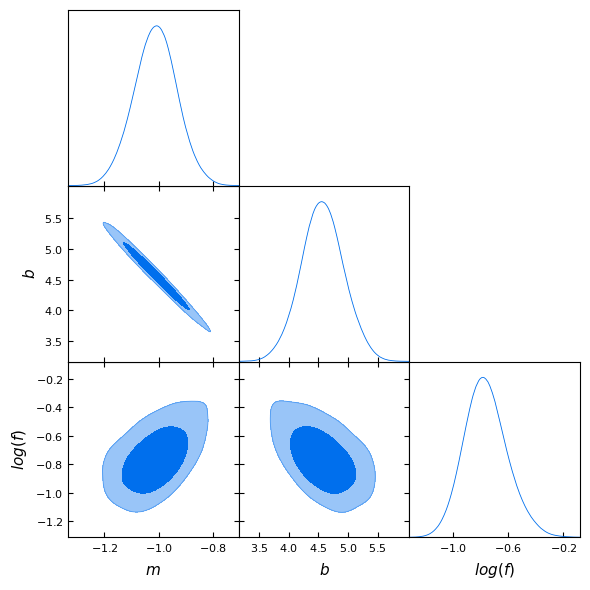

In [14]:
import math as m
from getdist.plots import GetDistPlotter

outnewchains=out['newchains']['Reweighted']
length = np.shape(outnewchains['b'])[0]
#print(length)
arraybma = np.zeros(shape=(length, 3))      #change 3/4 is adding/taking away weight column
#print(arraybma)
#print(outnewchains['a'])
for i in range(length):
    arraybma[i][0] = outnewchains['m'][i]
    arraybma[i][1] = outnewchains['b'][i]
    arraybma[i][2] = outnewchains['log(f)'][i]
    #arraybma[i][3] = outnewchains['weight'][i]


## check to find NaN and tke them out
newlength = 0
#print(length)
for i in range(length):
    if m.isnan(arraybma[i][0]):
        #print("break here")
        break
    newlength+=1

arraybma = arraybma[:newlength]
newweights = outnewchains['weight'].to_numpy() 
newweights = newweights[:newlength]
#print(arraybma) 
#print(np.shape(arraybma))


MCbmasamples = MCSamples(samples=arraybma, weights=newweights, names = ['m','b','log(f)'], labels=['m','b','log(f)'], label="BMA")

g = GetDistPlotter()
# Add the sample to the plotter
g.triangle_plot([MCbmasamples], filled=True)
# Show the plot
plt.show()

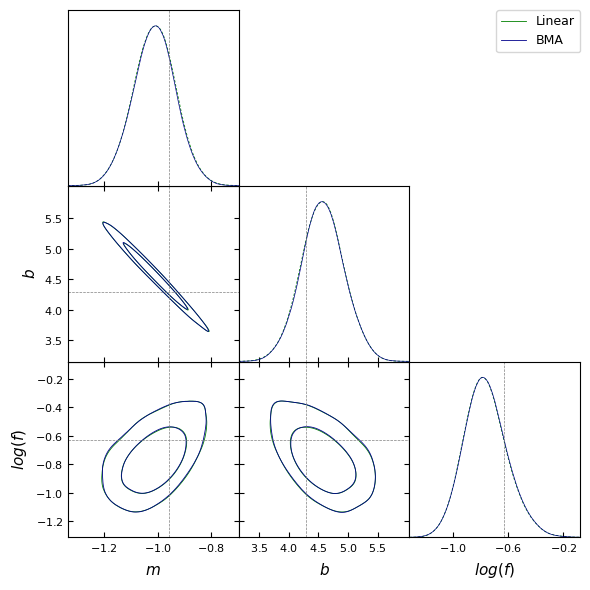

In [18]:
g = plots.get_subplot_plotter()
g.triangle_plot([gdsamples, MCbmasamples], filled=False, legend_labels=['Linear','BMA'], 
                markers={'m':m_true,'b':b_true,'log(f)':np.log(f_true)}, line_args=[{'ls':'--', 'color':'green'},
               {'lw':0.5, 'color':'darkblue'}], contour_colors=['green','darkblue'])